In [1]:
%load_ext autoreload
%autoreload 2
import torch
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from HPA_CC.models.train import find_checkpoint_file, ClassifierLit
from HPA_CC.models.utils import classifier_inference 
from HPA_CC.data.data_viz import save_image, annotate_cell_image
from HPA_CC.data.dataset import RefImDM, RefCLSDM, RefImDM

from config import HOME, HPA_DS_PATH, FUCCI_DS_PATH
classes = ["M-G1", "G1", "S-G2", "G2"]
protein = "CCNB1"
data_name = "minimal"

In [2]:
df = pd.read_csv(HOME / 'data' / 'ifimages_v23.csv')
print(df.columns)
df.head()

Index(['filename', 'jpg_prefix', 'if_plate_id', 'position', 'sample', 'status',
       'Image status name', 'locations', 'staining characteristics',
       'unspecific', 'antibody', 'ensembl_ids', 'gene_names', 'atlas_name',
       'versions', 'earliest_version', 'first_released', 'latest_version',
       'Spatial cell cycle', 'Intensity cell cycle', 'Annotated cell cycle',
       'gain', 'x_pos', 'y_pos', 'z_pos', 'Experiment state', 'Ab state',
       'Max tpm', 'Finished in genes', 'Protocol',
       'Gene reliability (in release)', 'Gene reliability (lims)',
       'Cell count', 'well_location_predictions_all'],
      dtype='object')


,filename,jpg_prefix,if_plate_id,position,sample,status,Image status name,locations,staining characteristics,unspecific,...,z_pos,Experiment state,Ab state,Max tpm,Finished in genes,Protocol,Gene reliability (in release),Gene reliability (lims),Cell count,well_location_predictions_all
0,/archive/1/1_A1_1_,https://lims.proteinatlas.org/images/992/1_A1_1_,1,A1,1,35,Annotated / Proteinatlas,Golgi apparatus,NaN,0.0,...,NaN,IF_FINISHED,IF_FINISHED,16.13,ENSG00000066455,PFA,Supported,Supported,7.0,NaN
1,/archive/1/1_A1_2_,https://lims.proteinatlas.org/images/992/1_A1_2_,1,A1,2,35,Annotated / Proteinatlas,Golgi apparatus,NaN,0.0,...,NaN,IF_FINISHED,IF_FINISHED,16.13,ENSG00000066455,PFA,Supported,Supported,6.0,NaN
2,/archive/1/1_A3_1_,https://lims.proteinatlas.org/images/2899/1_A3_1_,1,A3,1,35,Annotated / Proteinatlas,"Cytosol,Nucleoplasm",NaN,0.0,...,NaN,IF_FINISHED,IF_FINISHED,2.74,ENSG00000183092,PFA,Approved,Approved,4.0,NaN
3,/archive/1/1_A3_2_,https://lims.proteinatlas.org/images/2899/1_A3_2_,1,A3,2,35,Annotated / Proteinatlas,"Cytosol,Nucleoplasm",NaN,0.0,...,NaN,IF_FINISHED,IF_FINISHED,2.74,ENSG00000183092,PFA,Approved,Approved,6.0,NaN
4,/archive/1/1_A6_1_,https://lims.proteinatlas.org/images/609/1_A6_1_,1,A6,1,35,Annotated / Proteinatlas,"Endoplasmic reticulum,Nuclear membrane",NaN,0.0,...,NaN,IF_FINISHED,IF_FINISHED,81.38,ENSG00000102119,PFA,Enhanced,Enhanced,5.0,NaN


In [3]:
print(df[["filename", "antibody", "gene_names"]].values[0])

['/archive/1/1_A1_1_' 'HPA000992' 'GOLGA5']


In [4]:
def prefix_to_well(filename):
    image_id = filename.split('/')[-1]
    return '_'.join(image_id.split('_')[:2])

df["well"] = df["filename"].apply(prefix_to_well)
print(df["well"].values)

['1_A1' '1_A1' '1_A3' ... '2172_F7' '2172_H8' '2172_H8']


In [5]:
CCD_prots = ["DUSP19", "DUSP18", "PAPSS1", "N6AMT1", "PHLDB1", "FLI1", "TTC21B", "PC", "UGDH", 
             "ORC6", "ZNF32", "CCNE1", "CCNB1", "AURKB", "BUB1B", "DPH2", "GMNN", "CDT1", "ANLN"]
ccd_rows = df["gene_names"].isin(CCD_prots) & df["atlas_name"].isin(["U2OS"])
ccd_df = df[ccd_rows]
print(ccd_df["filename"].values[0])
print(ccd_df[["well", "antibody", "gene_names"]].values[0])

/archive/91/91_H6_1_
['91_H6' 'HPA008419' 'BUB1B']


# Setup and Data Prep

In [6]:
# Pick a protein
DS_HOME = HPA_DS_PATH
# DS_HOME = FUCCI_DS_PATH
prot_well_names = ccd_df[ccd_df["gene_names"] == protein]["well"].unique()
prot_abs = ccd_df[ccd_df["gene_names"] == protein]["antibody"].unique()
print(prot_well_names)
print(prot_abs)
# prot_well_names = ["chamber--U01--V00"]

['663_E2' '845_A6' '1671_B6']
['CAB000115' 'HPA030741' 'HPA061448']


<Figure size 640x480 with 0 Axes>

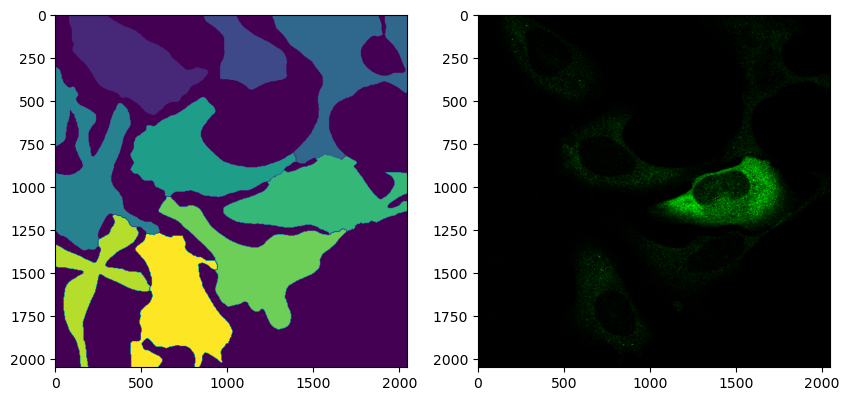

<Figure size 640x480 with 0 Axes>

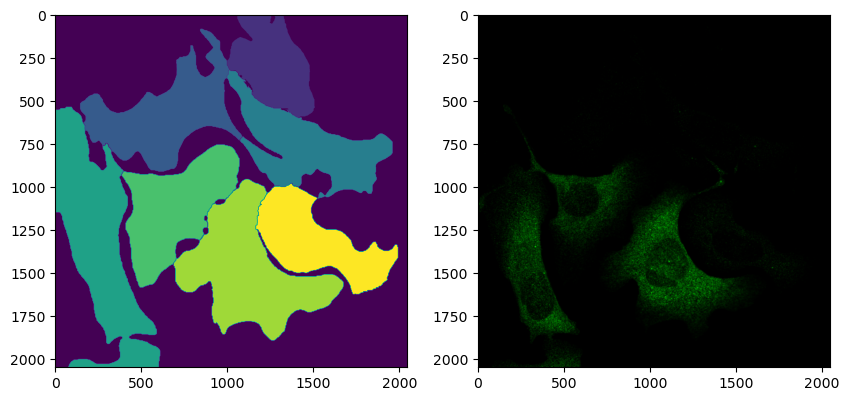

<Figure size 640x480 with 0 Axes>

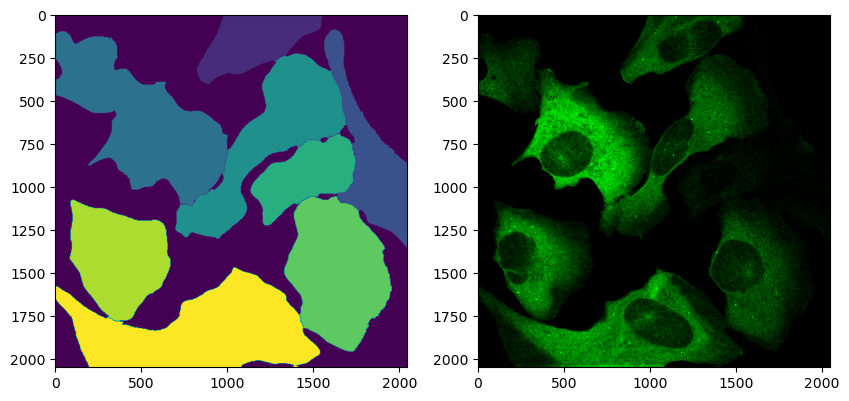

<Figure size 640x480 with 0 Axes>

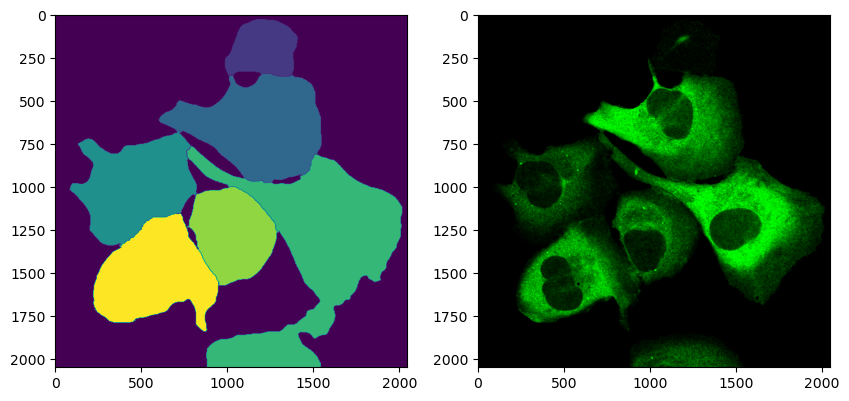

<Figure size 640x480 with 0 Axes>

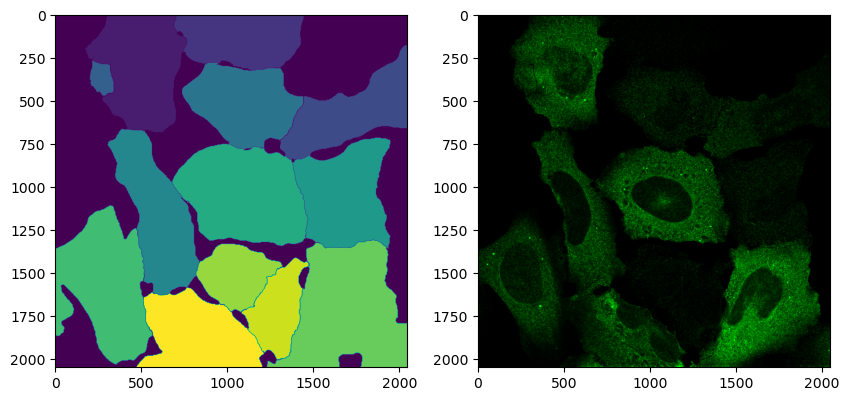

<Figure size 640x480 with 0 Axes>

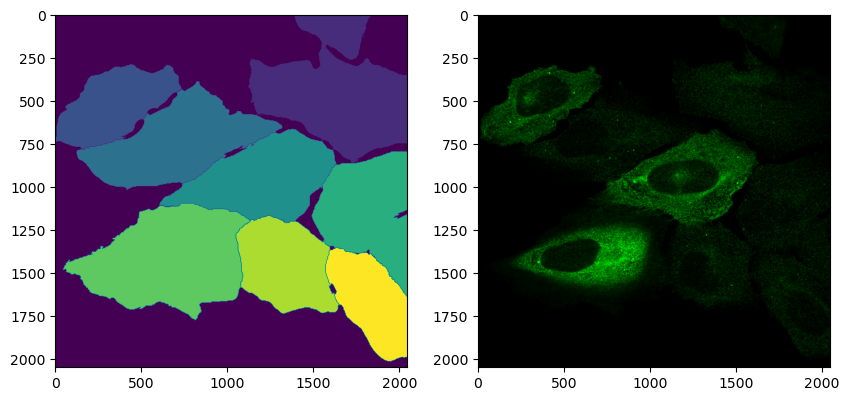

In [7]:
# prep data needed for model inference and visualization

image_paths = []
cell_mask_paths = []
for well in prot_well_names:
    # should really get these from the dataset config
    image_paths.append(DS_HOME / well / f"imagesmin_max.npy")
    cell_mask_paths.append(DS_HOME / well / f"cell_masks_no_border_rm_1000_sharp_none.npy")
    # cell_mask_paths.append(DS_HOME / well / f"cell_masks_no_border_rm_1000_sharp_1250.npy")

images = np.concatenate([np.load(p) for p in image_paths])

masks = [np.load(p) for p in cell_mask_paths]
n_per_well = [len(m) for m in masks]
masks = np.concatenate(masks)

ref_images = images[:, :2, ...]
# color_images = [save_image(torch.Tensor(I[[0, 1, 3]]), HOME / "temp.png", cmaps=["pure_blue", "pure_red", "pure_green"]) for I in images]
color_images = [save_image(torch.Tensor(I[[3]]), HOME / "temp.png", cmaps=["pure_green"]) for I in images]
# color_images = [save_image(torch.Tensor(I), HOME / "temp.png", cmaps=["pure_blue", "pure_yellow", "pure_green", "pure_red"]) for I in images]
# target_images = [save_image(torch.Tensor(I[[2, 3]]), HOME / "temp.png", cmaps=["pure_green", "pure_red"]) for I in images]

for i in range(len(color_images)):
    plt.clf()
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(masks[i])
    ax[1].imshow(color_images[i])
    plt.show()

sc_images = torch.concat([torch.load(DS_HOME / well / "images_minimal.pt") for well in prot_well_names])
assert len(sc_images) == sum([len(np.unique(m)) - 1 for m in masks])

In [8]:
from torch.utils.data import DataLoader
from HPA_CC.data.dataset import SimpleDataset


log_dirs_home = Path("/data/ishang/pseudotime_pred/")
device = "cuda:0"
model_name = "Conv Classifier"
# model_hash = "85zktev1" # og
# model_hash = "ikgoxh4k" # scope + aug
# model_hash = "f557ujip" # gamma 3
model_hash = "f1tpq0n2" # gamma 3 continued
checkpoint_file = find_checkpoint_file(model_hash, log_dirs_home, best=True)
phase_model = ClassifierLit.load_from_checkpoint(checkpoint_file)
phase_model.to(device)
phase_model.eval()
dataset = SimpleDataset(tensor=sc_images[:, :2, ...])
dataloader = DataLoader(dataset, batch_size=32, num_workers=1, shuffle=False)
# phase_preds = []
# with torch.no_grad():
#     for batch in iter(dataloader):
#         batch = batch.to(device)
#         batch_preds = phase_model(batch).cpu()
#         phase_preds.append(batch_preds)
# phase_preds = torch.cat(phase_preds)
# phase_preds = phase_preds.argmax(dim=1).numpy()
# print(phase_preds.shape)
phase_preds = classifier_inference(phase_model, dataloader, device)

/home/ishang/miniconda3/envs/hpa-cc-copy/lib/python3.9/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1699449181081/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


# Annotated Images

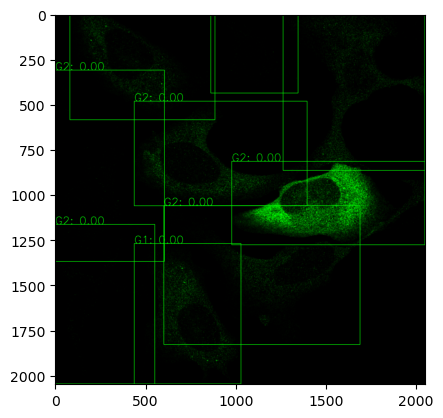

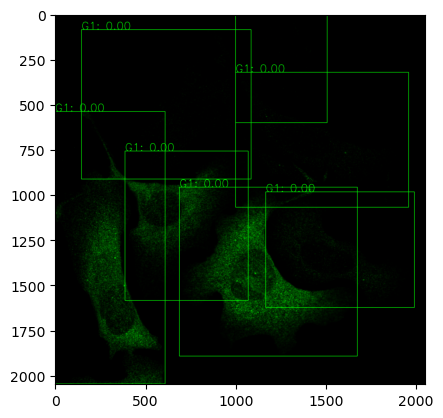

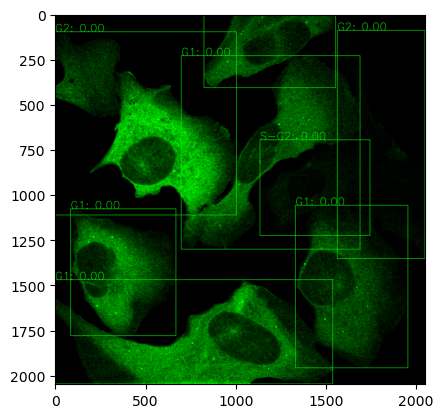

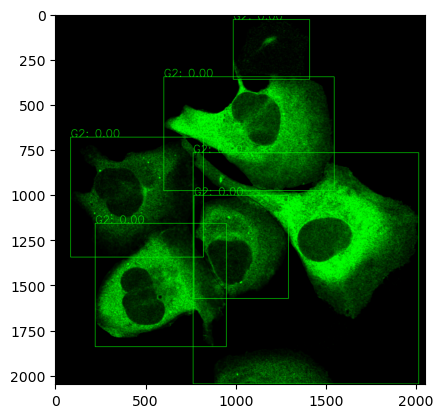

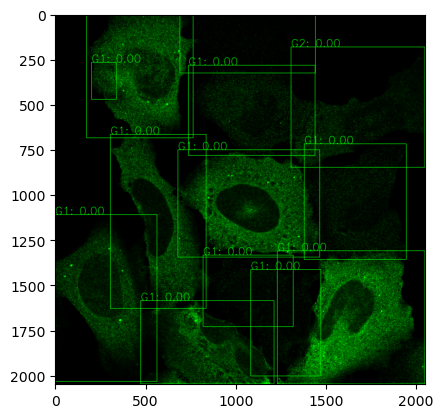

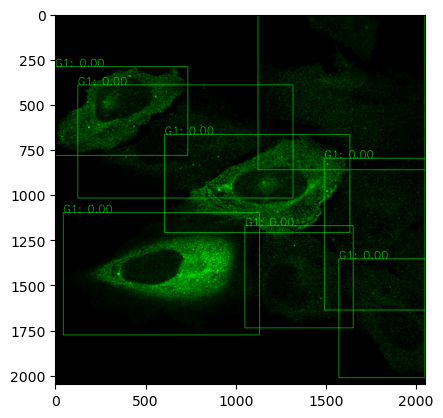

In [9]:
classes = ["M-G1", "G1", "S-G2", "G2"]
cell_idx = 0
for image, mask in zip(color_images, masks):
# for image, mask in zip(target_images, masks):
    n_cells = len(np.unique(mask)) - 1
    phases = phase_preds[cell_idx:cell_idx + n_cells]
    phases = [classes[p] for p in phases]
    image = np.array(image)
    annotated_image = annotate_cell_image(image, mask, np.zeros((n_cells,)), phases)
    cell_idx += n_cells
    plt.clf()
    plt.imshow(annotated_image)
    plt.show()

# HPA Prediction Histograms

In [10]:
HPA_dm = RefImDM(HPA_DS_PATH, data_name, 32, 1, inference=True)
FUCCI_dm = RefImDM(FUCCI_DS_PATH, data_name, 32, 1, split=(0.64, 0.16, 0.2), label="phase", scope=True)
# CCNB1_dm = RefImDM(CCNB1_DS_PATH, data_name, 32, 1, split=(0.64, 0.16, 0.2), label="phase", scope=True)

Loading dataset images: 100%|██████████| 1/1 [00:04<00:00,  4.30s/it]


Loaded 1870 images from 68 files.
X shape: torch.Size([1870, 2, 512, 512])


Loading dataset images: 100%|██████████| 1/1 [01:01<00:00, 61.68s/it]


Loaded 31737 images from 136 files.
X shape: torch.Size([31737, 2, 512, 512])
Loading /data/ishang/FUCCI-dataset-well/minimal_sample_phase_scope.pt
Y shape: torch.Size([31737, 4])


In [11]:
h_phase_preds = classifier_inference(phase_model, HPA_dm.inference_dataloader(), device)
f_phase_preds_val = classifier_inference(phase_model, FUCCI_dm.val_dataloader(), device)
f_phase_preds_test = classifier_inference(phase_model, FUCCI_dm.test_dataloader(), device)
f_phase_preds = np.concatenate([f_phase_preds_val, f_phase_preds_test])

In [12]:
def get_img_labels(data):
    print(data.shape)
    well_label = 0
    img_labels = np.zeros((len(data),))
    uq_intensities = np.unique(data[:, 1536:], axis=0)
    # uq_intensities = np.unique(data[:, :1536], axis=0)
    for i in range(len(img_labels)):
        well_label = np.where(np.all(uq_intensities == data[i, 1536:], axis=1))[0][0]
        # well_label = np.where(np.all(uq_intensities == data[i, :1536], axis=1))[0][0]
        img_labels[i] = well_label
    print(len(np.unique(img_labels)))
    return img_labels, uq_intensities
hpa_img_dm = RefCLSDM(HPA_DS_PATH, data_name, 32, 1, inference=True, concat_well_stats=True)
fucci_img_dm = RefCLSDM(FUCCI_DS_PATH, data_name, 32, 1, label="phase", split=(0.64, 0.16, 0.2), concat_well_stats=True, scope=True)
h_img_labels, h_img_ints = get_img_labels(hpa_img_dm.dataset.X.numpy())
f_non_train_data = np.concatenate([fucci_img_dm.dataset.X[fucci_img_dm.split_indices["val"]].numpy(), fucci_img_dm.dataset.X[fucci_img_dm.split_indices["test"]].numpy()])
f_img_labels, f_img_ints = get_img_labels(f_non_train_data)

Loading /data/ishang/all_HPA-CC-dataset/embeddings_minimal_dino_hpa.pt
Loading /data/ishang/all_HPA-CC-dataset/intensity_distributions_minimal.pt
X shape before intensity stats: torch.Size([1870, 1536])
X shape: torch.Size([1870, 2048])
Loading /data/ishang/FUCCI-dataset-well/embeddings_minimal_dino_hpa.pt
Loading /data/ishang/FUCCI-dataset-well/intensity_distributions_minimal.pt
X shape before intensity stats: torch.Size([31737, 1536])
X shape: torch.Size([31737, 2048])
Loading /data/ishang/FUCCI-dataset-well/minimal_sample_phase_scope.pt
Y shape: torch.Size([31737, 4])
(1870, 2048)
134
(11425, 2048)
2163


In [13]:
f_phase = torch.concat([fucci_img_dm.dataset.Y[fucci_img_dm.split_indices["val"]], fucci_img_dm.dataset.Y[fucci_img_dm.split_indices["test"]]]).numpy()
f_phase = np.argmax(f_phase, axis=1)

/tmp/ipykernel_628215/3325323313.py:9: RuntimeWarning: invalid value encountered in scalar divide
  spread = ((class_cts ** 2).sum() - N) / (N * (N - 1))


<Figure size 640x480 with 0 Axes>

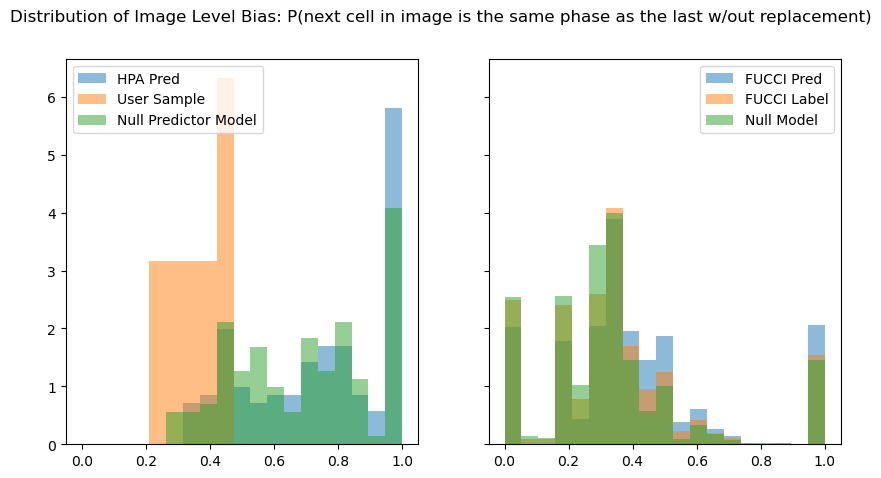

In [14]:
import numpy as np
num_classes = 4
def img_spreads(sc_phase_preds, img_labels):
    img_phase_spreads = []
    for i in sorted(np.unique(img_labels)):
        img_phase_preds = sc_phase_preds[img_labels == i]
        N = len(img_phase_preds)
        class_cts = np.unique(img_phase_preds, return_counts=True)[1]
        spread = ((class_cts ** 2).sum() - N) / (N * (N - 1))
        # spread = (class_cts ** 2).sum() / (N ** 2)
        # if spread == 0:
        #     print(img_phase_preds, class_cts, N, spread)
        img_phase_spreads.append(spread)
    return img_phase_spreads

h_img_spreads = img_spreads(h_phase_preds, h_img_labels)
f_img_spreads = img_spreads(f_phase_preds, f_img_labels)
f_img_spreads_ref = img_spreads(f_phase, f_img_labels)
user_img_spreads = [32/72, 12/30, 32/72, 14/42, 20/72, 10/42]
# user_img_spreads = [41/81, 18/36, 41/81, 21/49, 29/81, 17/49, 53/81, 29/49, 41/121, 50/144, 18/36, 30/64]

null_phases, null_img_labels = [], []
for i in range(1000):
    n_cells = np.random.randint(5, 8) if np.random.rand() < 0.8 else np.random.randint(8, 12)
    null_img_labels.extend([i] * n_cells)
    phase = np.random.choice(f_phase, n_cells)
    null_phases.extend(phase)
null_phases = np.array(null_phases)
null_img_spreads = img_spreads(np.array(null_phases), np.array(null_img_labels))

def generate_pred_img_spreads(phase_preds, imgs_n_cells):
    null_pred_img_labels = []
    img_idx = 0
    while len(null_pred_img_labels) < len(phase_preds):
        # n_cells = np.random.randint(3, 5) if np.random.rand() < 0. else np.random.randint(6, 12)
        n_cells = np.random.choice(imgs_n_cells)
        null_pred_img_labels.extend([img_idx] * n_cells)
        img_idx += 1
    null_pred_img_labels.extend([img_idx] * (len(phase_preds) - len(null_pred_img_labels)))
    null_pred_img_labels = null_pred_img_labels[:len(phase_preds)]
    pred_img_spreads = img_spreads(phase_preds, np.array(null_pred_img_labels))
    return pred_img_spreads

null_img_spreads = generate_pred_img_spreads(f_phase, np.unique(f_img_labels, return_counts=True)[1])
null_pred_img_spreads = generate_pred_img_spreads(h_phase_preds, np.unique(h_img_labels, return_counts=True)[1])

bins = np.linspace(0, 1, 20)
plt.clf()
fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharey=True, sharex=True)
ax[0].hist(h_img_spreads, bins=bins, alpha=0.5, density=True, label="HPA Pred")
ax[0].hist(user_img_spreads, bins=bins, alpha=0.5, density=True, label="User Sample")
ax[0].hist(null_pred_img_spreads, bins=bins, alpha=0.5, density=True, label="Null Predictor Model")
ax[0].legend()
ax[1].hist(f_img_spreads, bins=bins, alpha=0.5, density=True, label="FUCCI Pred")
ax[1].hist(f_img_spreads_ref, bins=bins, alpha=0.5, density=True, label="FUCCI Label")
ax[1].hist(null_img_spreads, bins=bins, alpha=0.5, density=True, label="Null Model")
ax[1].legend()
plt.suptitle("Distribution of Image Level Bias: P(next cell in image is the same phase as the last w/out replacement)")
plt.show()

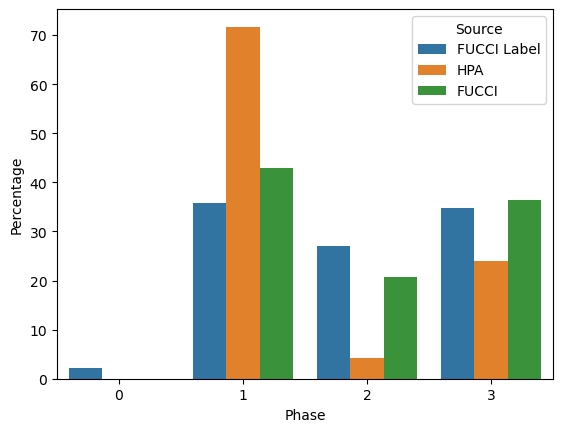

In [19]:
from collections import Counter
import matplotlib.pyplot as plt

# Calculate the frequency of each unique value
h_phase_counter = Counter(h_phase_preds)
f_phase_counter = Counter(f_phase_preds)
f_label_counter = Counter(f_phase)

# Calculate the total number of values
total_h_phase = len(h_phase_preds)
total_f_phase = len(f_phase_preds)
total_f_label = len(f_phase)

# Calculate densities/percentages
h_phase_percentages = {k: (v / total_h_phase) * 100 for k, v in h_phase_counter.items()}
f_phase_percentages = {k: (v / total_f_phase) * 100 for k, v in f_phase_counter.items()}
f_label_percentages = {k: (v / total_f_label) * 100 for k, v in f_label_counter.items()}

# Convert dictionaries to lists for seaborn
h_phase_data = list(h_phase_percentages.items())
f_phase_data = list(f_phase_percentages.items())
f_label_data = list(f_label_percentages.items())

# Create DataFrame for seaborn
df = pd.DataFrame(h_phase_data + f_phase_data + f_label_data, columns=['Phase', 'Percentage'])
df['Source'] = ['HPA']*len(h_phase_data) + ['FUCCI']*len(f_phase_data) + ['FUCCI Label']*len(f_label_data)

plt.clf()
sns.barplot(x='Phase', y='Percentage', hue='Source', data=df)
plt.show()

<Figure size 640x480 with 0 Axes>

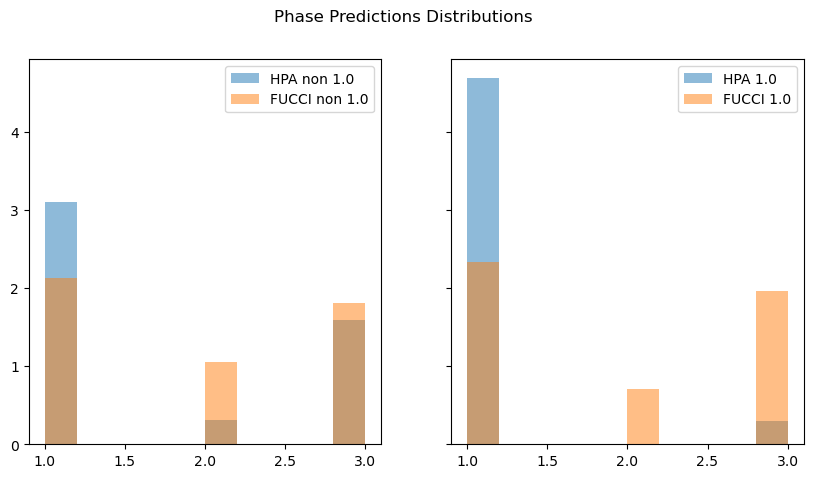

In [16]:
h_1_imgs = np.where(np.array(h_img_spreads) == 1.0)[0]
h_1_indices = np.where(np.isin(h_img_labels, h_1_imgs))
h_non_1_imgs = np.where(np.array(h_img_spreads) != 1.0)[0]
h_non_1_indices = np.where(np.isin(h_img_labels, h_non_1_imgs))
f_1_imgs = np.where(np.array(f_img_spreads) == 1.0)[0]
f_1_indices = np.where(np.isin(f_img_labels, f_1_imgs))
f_non_1_imgs = np.where(np.array(f_img_spreads) != 1.0)[0]
f_non_1_indices = np.where(np.isin(f_img_labels, f_non_1_imgs))
plt.clf()
fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)
ax[0].hist(h_phase_preds[h_non_1_indices], density=True, alpha=0.5, label="HPA non 1.0")
ax[0].hist(f_phase_preds[f_non_1_indices], density=True, alpha=0.5, label="FUCCI non 1.0")
ax[1].hist(h_phase_preds[h_1_indices], density=True, alpha=0.5, label="HPA 1.0")
ax[1].hist(f_phase_preds[f_1_indices], density=True, alpha=0.5, label="FUCCI 1.0")
ax[0].legend()
ax[1].legend()
plt.suptitle("Phase Predictions Distributions")
plt.show()

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)
plt.clf()
plt.suptitle("Cell Count Distributions")
plt.show()

<Figure size 1000x500 with 0 Axes>

(134, 3) (2163, 3)


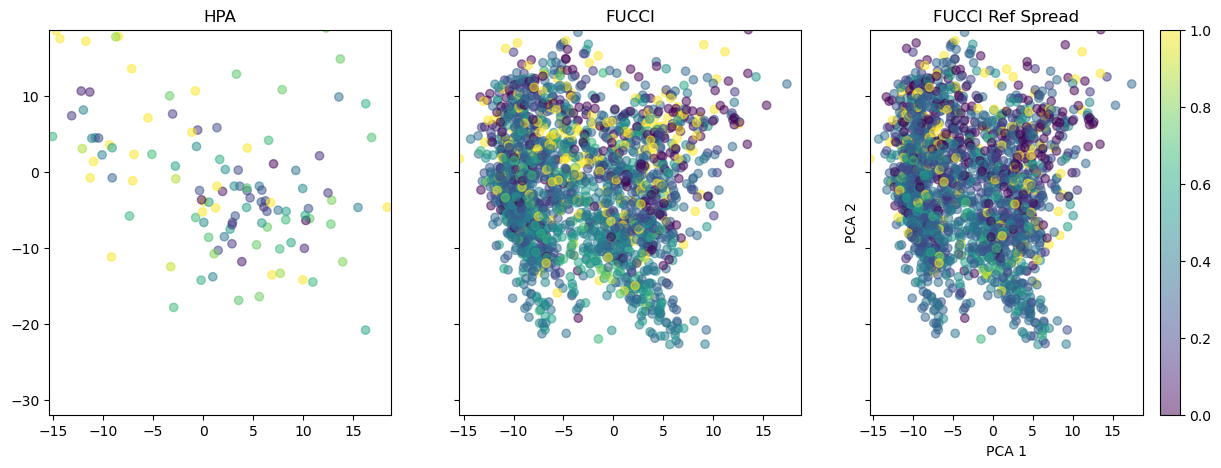

In [21]:
scale, pca = StandardScaler(), PCA(n_components=3)
h_int_samples = h_img_ints[np.random.choice(len(h_img_ints), 1000)]
f_int_samples = f_img_ints[np.random.choice(len(f_img_ints), 1000)]
fit_samples = np.concatenate([h_int_samples, f_int_samples], axis=0)
scale.fit(fit_samples)
pca.fit(scale.transform(fit_samples))
X_pca = pca.transform(scale.transform(np.concatenate([h_img_ints, f_img_ints], axis=0)))
# X_pca = pca.fit_transform(scale.fit_transform(np.concatenate([h_img_ints, f_img_ints], axis=0)))
h_pca = X_pca[:len(h_img_ints)]
f_pca = X_pca[len(h_img_ints):]
print(h_pca.shape, f_pca.shape)

fig, ax = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
x_min, y_min = np.min(f_pca[:, 0]), np.min(f_pca[:, 1])
x_max, y_max = np.max(f_pca[:, 0]), np.max(f_pca[:, 1])
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
ax[0].scatter(h_pca[:, 0], h_pca[:, 1], c=h_img_spreads, cmap="viridis", alpha=0.5)
ax[0].set_title("HPA")
sc = ax[1].scatter(f_pca[:, 0], f_pca[:, 1], c=f_img_spreads, cmap="viridis", alpha=0.5)
ax[1].set_title("FUCCI")
sc = ax[2].scatter(f_pca[:, 0], f_pca[:, 1], c=f_img_spreads_ref, cmap="viridis", alpha=0.5)
ax[2].set_title("FUCCI Ref Spread")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.colorbar(sc)
plt.show()

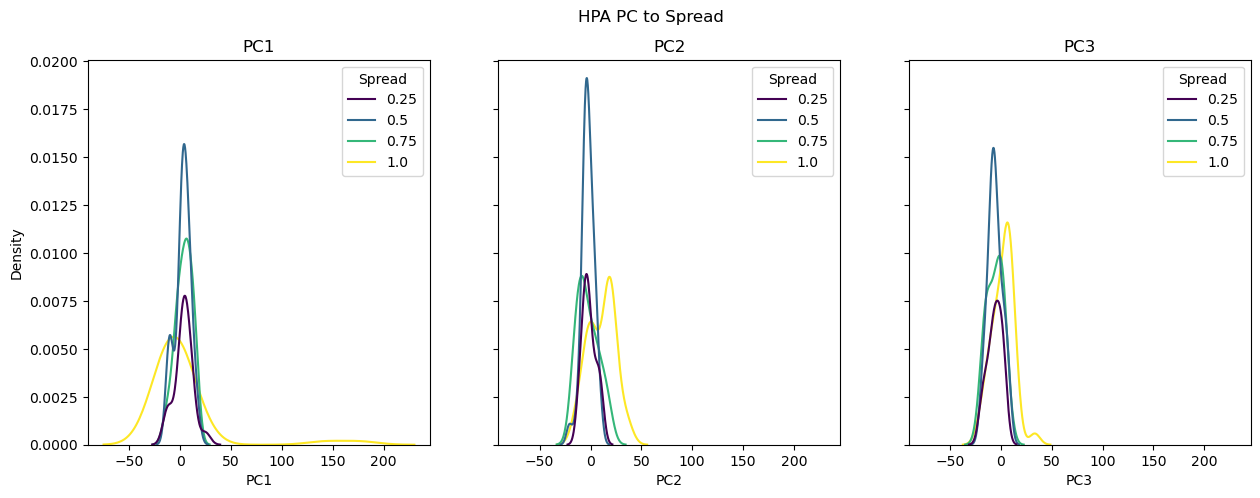

In [22]:
bins = np.linspace(0.2, 1, 4)
disc_h_img_spreads = np.digitize(h_img_spreads, bins) / 4
df = pd.DataFrame({f"PC{i+1}" : h_pca[:, i] for i in range(3)})
df["Spread"] = disc_h_img_spreads
fig, ax = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
for i in range(3):
    sns.kdeplot(data=df, x=f"PC{i+1}", hue="Spread", ax=ax[i], palette="viridis")
    ax[i].set_title(f"PC{i+1}")
plt.suptitle("HPA PC to Spread")
plt.show()

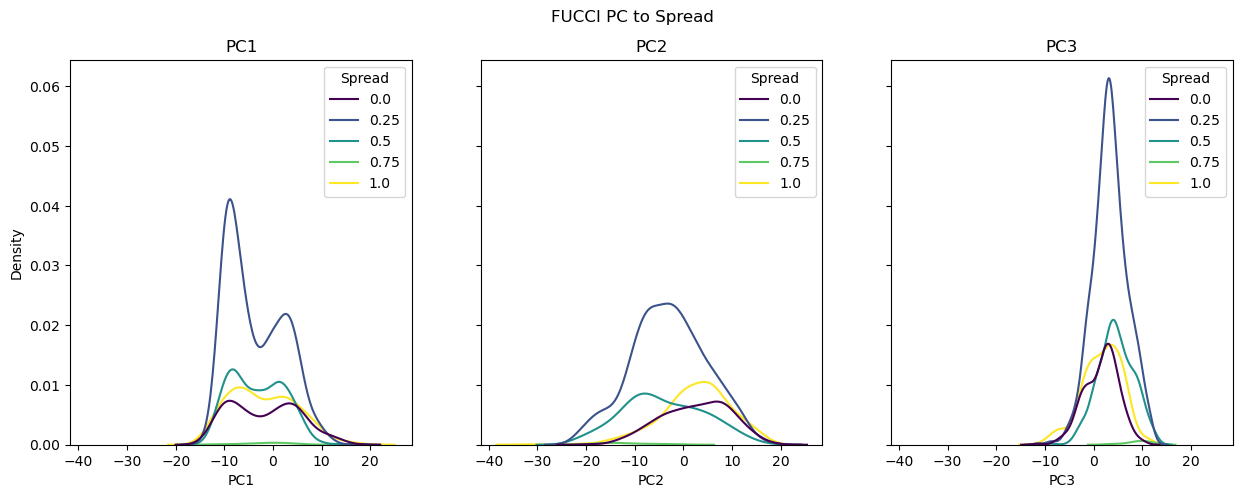

In [23]:
bins = np.linspace(0.2, 1, 4)
disc_f_img_spreads = np.digitize(f_img_spreads, bins) / 4
df = pd.DataFrame({f"PC{i+1}" : f_pca[:, i] for i in range(3)})
df["Spread"] = disc_f_img_spreads
fig, ax = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
for i in range(3):
    sns.kdeplot(data=df, x=f"PC{i+1}", hue="Spread", ax=ax[i], palette="viridis")
    ax[i].set_title(f"PC{i+1}")
plt.suptitle("FUCCI PC to Spread")
plt.show()

In [ ]:
from sklearn.cluster import SpectralClustering, KMeans, DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
# kmeans = KMeans(n_clusters=2, random_state=0).fit(f_pca)
# sc = SpectralClustering(2).fit(f_pca[:, :3])
# db = DBSCAN(eps=15).fit(f_pca)
# db = AgglomerativeClustering(n_clusters=2).fit(f_pca[:, :3])
# gm = GaussianMixture(n_components=3).fit(f_pca[:, :3])
gm = GaussianMixture(n_components=3).fit(f_pca)
# cluster_labels = sc.labels_
cluster_labels = gm.predict(f_pca)

plt.clf()
for c in np.unique(cluster_labels):
    label_samples = f_pca[cluster_labels == c]
    plt.scatter(label_samples[:, 0], label_samples[:, 1], alpha=0.5, label=f"Cluster {c}")
plt.legend()
plt.show()
# plt.scatter(f_pca[:, 0], f_pca[:, 1], c=cluster_labels, cmap="RdYlGn", alpha=0.5)

In [ ]:
bins = np.linspace(0.0, 1.0, 10)
plt.clf()
for c in np.unique(cluster_labels):
    plt.hist(torch.Tensor(f_img_spreads_ref)[cluster_labels == c].numpy(), bins=bins, alpha=0.5, density=True, label=f"Cluster {c}")
plt.legend()
plt.title("FUCCI Img Label Spread by Cluster")
plt.show()

In [ ]:
distances = np.zeros((len(np.unique(cluster_labels)), len(h_pca)))
for i, h in enumerate(h_pca):
    for c in np.unique(cluster_labels):
        f = f_pca[cluster_labels == c]
        distances[c, i] = np.min(np.linalg.norm(f - h, axis=1))

plt.clf()
for c in np.unique(cluster_labels):
    plt.hist(np.log(distances[c, :]), alpha=0.5, density=True, label=f"Cluster {c}")
plt.legend()
plt.title("Log Distance to Nearest FUCCI Cluster")
plt.show()

In [ ]:
%matplotlib ipympl
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(h_pca[:, 0], h_pca[:, 1], h_pca[:, 2], c=h_img_spreads, cmap="viridis", alpha=1.0)
f_pca_c0 = f_pca[cluster_labels == 0]
ax.scatter(f_pca_c0[:, 0], f_pca_c0[:, 1], f_pca_c0[:, 2], color='blue', alpha=0.5)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.show()

In [ ]:
%matplotlib ipympl
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(h_pca[:, 0], h_pca[:, 1], h_pca[:, 2], c=h_img_spreads, cmap="viridis", alpha=1.0)
f_pca_c1 = f_pca[cluster_labels == 1]
ax.scatter(f_pca_c1[:, 0], f_pca_c1[:, 1], f_pca_c1[:, 2], color='orange', alpha=0.5)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.show()

In [ ]:
%matplotlib ipympl
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(h_pca[:, 0], h_pca[:, 1], h_pca[:, 2], c=h_img_spreads, cmap="viridis", alpha=1.0)
f_pca_c2 = f_pca[cluster_labels == 2]
ax.scatter(f_pca_c2[:, 0], f_pca_c2[:, 1], f_pca_c2[:, 2], color='green', alpha=0.5)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.show()

In [ ]:
%matplotlib ipympl
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(h_pca[:, 0], h_pca[:, 1], h_pca[:, 2], c=h_img_spreads, cmap="viridis", alpha=1.0)
ax.scatter(f_pca_c0[:, 0], f_pca_c0[:, 1], f_pca_c0[:, 2], color='blue', alpha=0.5, label="Cluster 0")
ax.scatter(f_pca_c1[:, 0], f_pca_c1[:, 1], f_pca_c1[:, 2], color='orange', alpha=0.5, label="Cluster 1")
ax.scatter(f_pca_c2[:, 0], f_pca_c2[:, 1], f_pca_c2[:, 2], color='green', alpha=0.5, label="Cluster 2")
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.show()

In [ ]:
HPA_img_dm = RefImDM(HPA_DS_PATH, "minimal", 16, 1, split=(0.64, 0.16, 0.2), label="phase", scope=True, augment=False)
FUCCI_img_dm = RefImDM(FUCCI_DS_PATH, "minimal", 16, 1, split=(0.64, 0.16, 0.2), label="phase", scope=True, augment=True, same=True)

In [ ]:
import HPA_CC.utils.img_tools as tools
from tqdm import tqdm
import numpy as np
percentiles = np.linspace(0, 100, 2**8)
def calculate_image_percentiles(image_data_manager, percentiles):
    tools.silent = True
    h_sc_ints = []
    for batch in tqdm(image_data_manager.inference_dataloader()):
        ints, _ = tools.get_batch_percentiles(batch.numpy(), percentiles, non_zero=True)
        # h_sc_ints.append(ints.transpose(2, 1, 0))
        h_sc_ints.extend([ints.flatten()] * len(batch))
    h_sc_ints = np.stack(h_sc_ints)
    return h_sc_ints

h_sc_ints = calculate_image_percentiles(HPA_img_dm, np.linspace(0, 100, 2**8))
f_sc_ints = calculate_image_percentiles(FUCCI_img_dm, np.linspace(0, 100, 2**8))

In [ ]:
h_sc_ints.shape

In [ ]:
sc_scale, sc_pca = StandardScaler(), PCA(n_components=3)
h_sc_int_samples = h_sc_ints[np.random.choice(len(h_sc_ints), 1000)]
f_sc_int_samples = f_sc_ints[np.random.choice(len(f_sc_ints), 1000)]
fit_samples = np.concatenate([h_sc_int_samples, f_sc_int_samples], axis=0)
sc_scale.fit(fit_samples)
sc_pca.fit(sc_scale.transform(fit_samples))
X_sc_pca = sc_pca.transform(sc_scale.transform(np.concatenate([h_sc_ints, f_sc_ints], axis=0)))
h_sc_pca = X_sc_pca[:len(h_sc_ints)]
f_sc_pca = X_sc_pca[len(h_sc_ints):]
h_pca = X_sc_pca[:len(h_sc_ints)]
f_pca = X_sc_pca[len(h_sc_ints):]

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(h_sc_pca[:, 0], h_sc_pca[:, 1], h_sc_pca[:, 2], color='orange', alpha=0.5)
ax.scatter(f_sc_pca[:, 0], f_sc_pca[:, 1], f_sc_pca[:, 2], color='blue', alpha=0.5)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.show()